In [1]:
import librosa
import os
import pandas as pd
import glob
import numpy as np
import soundfile
from sklearn.model_selection import train_test_split

In [29]:
def extract_feature(file_name,mfcc,chroma,mel,zcr,rmse):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if zcr:
            zcr=np.mean(librosa.feature.zero_crossing_rate(y=X, frame_length=2048, hop_length=512).T,axis=0)
            result=np.hstack((result, zcr))
        if rmse:
            rmse=np.mean(librosa.feature.rms(S=stft,frame_length=2048, hop_length=512, pad_mode='reflect').T,axis=0)
            result=np.hstack((result, rmse))
    return result

In [30]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust','neutral','surprised','sad','angry']
len(observed_emotions)

8

In [31]:
def labels():
    x,y=[],[]
    for file in glob.glob("D:/AAA_video_course/Programming/dataset/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        y.append(emotion)
    return y

In [32]:
y = labels()
df = pd.DataFrame(y, columns =['emo'])
df

,emo
0,neutral
1,neutral
2,neutral
3,neutral
4,calm
...,...
1435,surprised
1436,surprised
1437,surprised
1438,surprised


In [33]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("D:/AAA_video_course/Programming/dataset/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True, zcr=True, rmse=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size)

In [34]:
df.groupby('emo').size()

emo
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
dtype: int64

In [35]:
final_labels = ['angry' ,       
'calm '  ,   
'disgust'   ,   
'fearful' ,    
'happy'   ,    
'neutral'  ,     
'sad',          
'surprised' ]

In [36]:
from matplotlib.pyplot import figure

bars = plt.barh(final_labels ,df.groupby('emo').size())
plt.bar_label(bars)

NameError: name 'plt' is not defined

In [37]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

<ipython-input-29-08d1a4acc2e8>:14: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
<ipython-input-29-08d1a4acc2e8>:14: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
<ipython-input-29-08d1a4acc2e8>:14: FutureWarning: Pass y=[ 3.0517578e-05  3.0517578e-05  0.0000000e+00 ... -3.0517578e-05
  0.0000000e+00 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
<ipython-input-29-08d1a4acc2e8>:14: FutureWarning: Pass y=[3.0517578e-05 3.0517578e-05 3.051757

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [11]:
x_train.shape,x_test.shape

((1152, 182), (288, 182))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [13]:
import time
start = time.time()

In [14]:
model=MLPClassifier(alpha=0.005, batch_size=128, epsilon=1e-06, hidden_layer_sizes=(500,), learning_rate='constant',activation='logistic',solver='adam',max_iter=800)
model.fit(x_train,y_train)

MLPClassifier(activation='logistic', alpha=0.005, batch_size=128, epsilon=1e-06,
              hidden_layer_sizes=(500,), max_iter=800)

In [15]:
model.classes_

array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'], dtype='<U9')

In [16]:
end = time.time()
train_time_total=end-start
print(train_time_total)

43.390904664993286


In [17]:
start = time.time()
y_pred=model.predict(x_test)
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Logistic-Accuracy: {:.2f}%".format(accuracy*100))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
end = time.time()
test_time_total=end-start
print(test_time_total)

Logistic-Accuracy: 66.32%
              precision    recall  f1-score   support

       angry       0.65      0.70      0.67        40
        calm       0.91      0.79      0.85        39
     disgust       0.54      0.62      0.58        40
     fearful       0.47      0.59      0.52        27
       happy       0.75      0.56      0.64        43
     neutral       0.54      0.87      0.67        15
         sad       0.76      0.61      0.68        36
   surprised       0.70      0.67      0.68        48

    accuracy                           0.66       288
   macro avg       0.67      0.68      0.66       288
weighted avg       0.68      0.66      0.67       288

0.011968851089477539


In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred,normalize='true')
conf_matrix= pd.DataFrame(cm,columns=None)
conf_matrix.to_csv(r'D:\thesis_codes\output\mlpconfusion_matrix.csv', index = False, header=False)

In [23]:
from imblearn.metrics import specificity_score
s=specificity_score(y_test,y_pred,average='macro')
print(s)

0.9518459733795392


In [24]:
from sklearn.metrics import roc_auc_score
y_pred=model.predict_proba(x_test)
auc=roc_auc_score(y_test, y_pred, average='macro',multi_class='ovo')
print(auc)

0.9238764028926739


In [25]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
y_pred=model.predict(x_test)
p=precision_score(y_test, y_pred,average='macro')
r=recall_score(y_test, y_pred,average='macro')
f=f1_score(y_test, y_pred,average='macro')
print(p,r,f)

0.6653666903723241 0.676881045849069 0.66180502298313


In [26]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(TPR)
print(FPR)

[0.7        0.79487179 0.625      0.59259259 0.55813953 0.86666667
 0.61111111 0.66666667]
[0.05641073 0.01051587 0.08665571 0.06317758 0.02599206 0.0383547
 0.02990956 0.05826258]


In [27]:
from pandas import DataFrame
C = {
     'test acc':[str(accuracy)],
     'precision(macro)':[str(p)],
     'recall(macro)':[str(r)],
     'f1(macro)':[str(f)],
     'specificity(macro)':[str(s)],
     'AUC(macro)':[str(auc)],
     'total train time':[str(train_time_total)],
     'total test time':[str(test_time_total)]}
df = DataFrame(C, columns= ['test acc','precision(macro)','recall(macro)','f1(macro)','specificity(macro)','AUC(macro)','total train time','total test time'])
export_csv = df.to_csv (r'E:\result2.csv', index = None, header=True) 
print (df)

             test acc    precision(macro)      recall(macro)  \
0  0.6631944444444444  0.6653666903723241  0.676881045849069   

          f1(macro)  specificity(macro)          AUC(macro)  \
0  0.66180502298313  0.9518459733795392  0.9238764028926739   

     total train time       total test time  
0  43.390904664993286  0.011968851089477539  


In [28]:
from pandas import DataFrame
C = {
     'TPR': TPR,
     'FPR': FPR}
df = DataFrame(C, columns= ['TPR','FPR'])
export_csv = df.to_csv (r'E:\result3.csv', index = None, header=True) 
print (df)

        TPR       FPR
0  0.700000  0.056411
1  0.794872  0.010516
2  0.625000  0.086656
3  0.592593  0.063178
4  0.558140  0.025992
5  0.866667  0.038355
6  0.611111  0.029910
7  0.666667  0.058263


In [29]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[28  0  5  1  0  1  1  4]
 [ 0 31  2  1  0  5  0  0]
 [ 8  1 25  1  2  1  2  0]
 [ 2  0  5 16  0  0  3  1]
 [ 4  0  2  8 24  0  1  4]
 [ 0  0  1  0  0 13  0  1]
 [ 1  1  1  5  1  1 22  4]
 [ 0  1  5  2  5  3  0 32]]


In [30]:
cm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
#The diagonal entries are the accuracies of each class
cm.diagonal()*100

array([70.        , 79.48717949, 62.5       , 59.25925926, 55.81395349,
       86.66666667, 61.11111111, 66.66666667])

Text(0.5, 1.0, 'accuracy of each class')

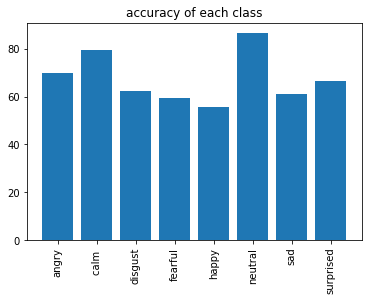

In [33]:
plt.bar(final_labels,cm.diagonal()*100)
plt.xticks(rotation=90)
plt.title("accuracy of each class")

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'angry'),
  Text(0, 1.5, 'calm '),
  Text(0, 2.5, 'disgust'),
  Text(0, 3.5, 'fearful'),
  Text(0, 4.5, 'happy'),
  Text(0, 5.5, 'neutral'),
  Text(0, 6.5, 'sad'),
  Text(0, 7.5, 'surprised')])

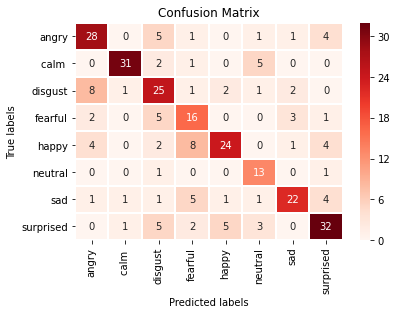

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True,linecolor='white', cmap='Reds', linewidth=2, fmt='', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(final_labels); ax.yaxis.set_ticklabels(final_labels);
plt.xticks(rotation=90)
plt.yticks(rotation=0)
